# Machine Learning Model for the Planetary Albedo
### By: Mariam Ahmed Amin


## Importing important libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor


## Task 1. Predicting the Lunar Albedo based on Chemical Composition
### This task aims to build a model that can predict Albedo from iron, potassium, thorium, therm and titanium.

### Reading and preprocessing the data

#### Define the functions that read data from files  

In [2]:
def readFeature1D(filename):
    with open(filename) as filePtr:
        allContent = filePtr.readlines()
        content = []
        for i in allContent:
            content+=i.split(",")
        
        
    return content

def readFeature2D(filename):
    with open(filename) as filePtr:
        allContent = filePtr.readlines()
        content = []
        for i in allContent:
            content.append([float(r) for r in i.split(",")])
        
        
    return content

#### Creating the dataframe from the 5 separate files

In [3]:
Fe = [float(i) for i in readFeature1D("Fe.txt")]
K = [float(i) for i in readFeature1D("K.txt")]
Th = [float(i) for i in readFeature1D("Th.txt")]
Ti = [float(i) for i in readFeature1D("Ti.txt")] 
Albedo = [float(i) for i in readFeature1D("Albedo.txt")] 
Therm = [float(i) for i in readFeature1D("Therm.txt")] 
print(len(K))

temp = {"Fe": Fe, "K": K, "Th": Th, "Ti":Ti,"Therm": Therm, "Albedo": Albedo}

task1Dataframe = pd.DataFrame(temp)


259200


#### View the Fe map 

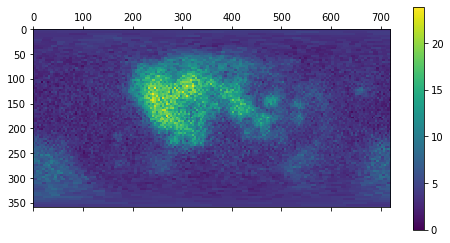

In [4]:
fe = readFeature2D("Fe.txt")
plt.matshow(fe)
plt.colorbar()
plt.show()

#### Data Scalling "Standarization of the input"


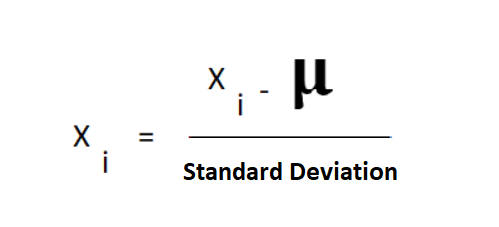

In [5]:
task1Dataframe.loc[:,["Fe", "K", "Th", "Ti","Therm"]] = (task1Dataframe.loc[:,["Fe", "K", "Th", "Ti","Therm"]]-task1Dataframe.loc[:,["Fe", "K", "Th", "Ti","Therm"]].mean())/(task1Dataframe.loc[:,["Fe", "K", "Th", "Ti","Therm"]].std())

### Analysing the dataset

In [6]:
task1Dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259200 entries, 0 to 259199
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Fe      259200 non-null  float64
 1   K       259200 non-null  float64
 2   Th      259200 non-null  float64
 3   Ti      259200 non-null  float64
 4   Therm   259200 non-null  float64
 5   Albedo  259200 non-null  float64
dtypes: float64(6)
memory usage: 11.9 MB


#####  There are no null values

In [7]:
task1Dataframe.describe()

,Fe,K,Th,Ti,Therm,Albedo
count,2.592000e+05,2.592000e+05,2.592000e+05,2.592000e+05,2.592000e+05,259200.000000
mean,1.403541e-16,-1.947413e-16,-1.070200e-16,-9.649346e-17,-9.807244e-16,0.291764
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.053083
min,-1.549510e+00,-1.071289e+00,-9.078206e-01,-6.513412e-01,-2.985169e+00,0.096897
25%,-5.601211e-01,-6.096475e-01,-5.582265e-01,-5.684233e-01,-3.512682e-01,0.271222
50%,-3.601840e-01,-3.158055e-01,-3.708137e-01,-3.169821e-01,3.343573e-01,0.305115
75%,1.218471e-01,2.124444e-01,7.945446e-02,6.447329e-02,6.762353e-01,0.326371
max,5.479770e+00,5.372674e+00,5.757668e+00,8.665940e+00,1.633568e+00,0.506560


##### It's obvious that after the standardization, the standard deviation =1 for all features. 

#### The  Correlation between the features shows the strength of the relation between them. 

<AxesSubplot:>

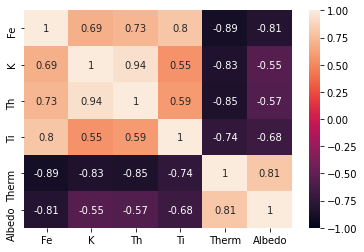

In [8]:
sns.heatmap(task1Dataframe.corr(), vmin=-1, vmax=1, annot=True)

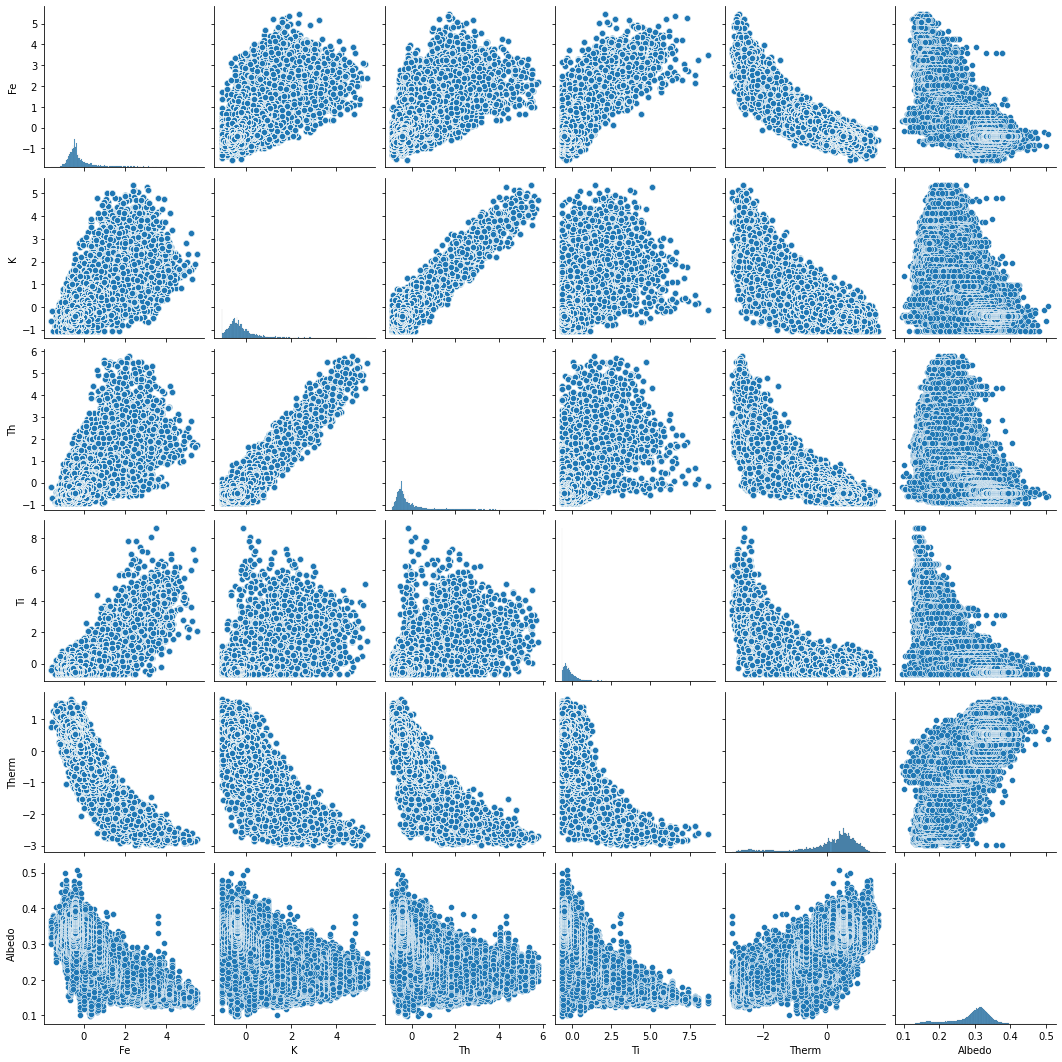

In [9]:
sns.pairplot(task1Dataframe)

##### There is a strong negative relation between:
-Fe and the Albedo.  
-therm and Fe.  
-therm and the K.  
-therm and the Th.  
-therm and the Ti.

##### There is a strong positive relation between:
-therm and the Albedo.    
-Ti and Fe.


#### Spliting the data into training and testing parts with the testing part size 0.3 of the dataset

In [10]:
x_train, x_test, y_train, y_test = train_test_split(task1Dataframe.loc[:,["Fe", "K", "Th", "Ti","Therm"]], task1Dataframe.loc[:,["Albedo"]], test_size=0.3)

In [11]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

### Selection of the best model for a specific Machine Learning algorithm by permutate features

In [12]:
# define all subsets of features
featuresSubsets = [["Therm"], ["Ti"], ["Ti", "Therm"], ["Th"], ["Th", "Therm"], ["Th", "Ti"], ["Th", "Ti", "Therm"], ["K"]
             , ["K", "Therm"], ["K", "Ti"], ["K", "Ti", "Therm"], ["K", "Th"], ["K", "Th", "Therm"], ["K", "Th", "Ti"]
             , ["K", "Th", "Ti", "Therm"] ,["Fe"] ,["Fe", "Therm"]  ,["Fe", "Ti"] ,["Fe", "Ti", "Therm"]
             , ["Fe", "Th"], ["Fe", "Th", "Therm"], ["Fe", "Th", "Ti"], ["Fe", "Th", "Ti", "Therm"], ["Fe", "K"], 
             ["Fe", "K", "Therm"], ["Fe", "K", "Ti"], ["Fe", "K", "Ti", "Therm"], ["Fe", "K", "Th"], 
             ["Fe", "K", "Th", "Therm"], ["Fe", "K", "Th", "Ti"], ["Fe", "K", "Th", "Ti", "Therm"]]
    

#build the model with features and keep the best model so far
def getBestModel(model, featuresList, x_train, y_train,  x_test, y_test):
    
    bestModel = model
    bestModel.fit(x_train[featuresList[0]],y_train)
    bestFeatures = featuresList[0]
    bestScore = bestModel.score( x_test[featuresList[0]], y_test)
    
    for i in range(1,len(featuresList)):
        temp = model
        temp.fit(x_train[featuresList[i]],y_train)
        score = temp.score(x_test[featuresList[i]], y_test)
        if(temp.score(x_test[featuresList[i]], y_test)>bestScore):
            bestModel = temp
            bestFeatures = featuresList[i]
            bestScore = score
            
    return bestModel, bestFeatures, bestScore



        

### Model 1:  The linear model 

In [13]:

reg = linear_model.BayesianRidge()
bestModel, bestFeatures, bestScore=getBestModel(reg, featuresSubsets, x_train, y_train,  x_test, y_test)
print("The model with best score has score = "+str(bestScore)+", with features: "+ str(bestFeatures))


The model with best score has score = 0.7375658953712845, with features: ['Fe', 'K', 'Th', 'Ti', 'Therm']


#### The score of the model = 0.734

### Model 2:  Multiple Layer Perceptron (Neural Network)

In [14]:
#y_train.ravel()
y_train.shape

(181440,)

In [15]:
regr = MLPRegressor(random_state=1, max_iter=600, learning_rate="adaptive", shuffle=True)

bestModel, bestFeatures, bestScore=getBestModel(regr, featuresSubsets, x_train, y_train,  x_test, y_test)
print("The model with best score has score = "+str(bestScore)+", with features: "+ str(bestFeatures))


The model with best score has score = 0.7792909219854138, with features: ['Fe', 'K', 'Th', 'Therm']


#### The score of the model is 0.777

###  The best model is the MLP with performance = 0.777

### Validate the model by visualizing its output wrt the actual output

#### Reading the actual output 

In [16]:
actualOutput = readFeature2D("Albedo.txt")
nRows = len(actualOutput)
nCols = len(actualOutput[0])
print(str(nRows)+" "+str(nCols))

360 720


#### Predicting the output from the input dataset to compare it to the actual output

In [17]:
predictedOutput = regr.predict(task1Dataframe.loc[:,["Fe", "K", "Th", "Ti","Therm"]])

# resizing the predicted output to be 2d 
predictedOutput.resize(nRows,nCols)
predictedOutput.shape

(360, 720)

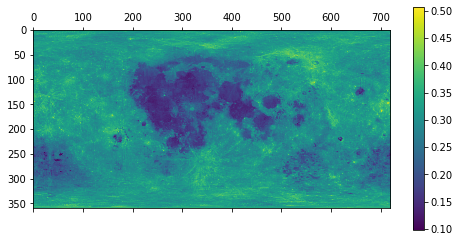

In [18]:
plt.matshow(actualOutput)
plt.colorbar()
plt.show()

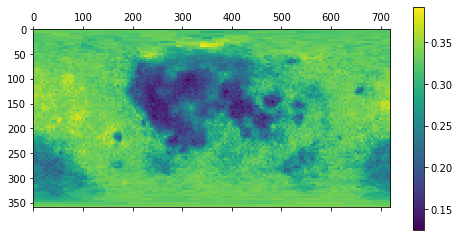

In [19]:
plt.matshow(predictedOutput)
plt.colorbar()
plt.show()

#### It's obvious that the predicted output is similar to the actual output.